In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [27]:
# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 5)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2

In [28]:
train_x

tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])

In [29]:
train_y

tensor([ 0.1792,  0.9998,  0.0938, -1.1426, -0.4768])

In [30]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

## Training the model

In [31]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.245   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.225   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 1.208   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 1.190   lengthscale: 0.554   noise: 0.555
Iter 5/50 - Loss: 1.171   lengthscale: 0.513   noise: 0.514
Iter 6/50 - Loss: 1.153   lengthscale: 0.474   noise: 0.476
Iter 7/50 - Loss: 1.136   lengthscale: 0.438   noise: 0.441
Iter 8/50 - Loss: 1.118   lengthscale: 0.403   noise: 0.408
Iter 9/50 - Loss: 1.100   lengthscale: 0.371   noise: 0.378
Iter 10/50 - Loss: 1.083   lengthscale: 0.340   noise: 0.350
Iter 11/50 - Loss: 1.067   lengthscale: 0.311   noise: 0.325
Iter 12/50 - Loss: 1.052   lengthscale: 0.285   noise: 0.302
Iter 13/50 - Loss: 1.040   lengthscale: 0.260   noise: 0.280
Iter 14/50 - Loss: 1.033   lengthscale: 0.237   noise: 0.261
Iter 15/50 - Loss: 1.030   lengthscale: 0.217   noise: 0.243
Iter 16/50 - Loss: 1.031   lengthscale: 0.199   noise: 0.226
Iter 17/50 - Loss: 1.035   length

## Make predictions with the model

In [32]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

## Prot the model fit

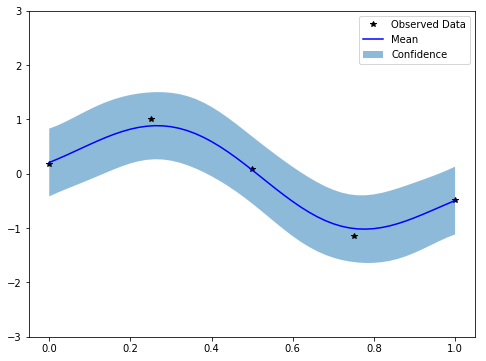

In [33]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])